In [2]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

# internal imports
from pympc.geometry.polyhedron import Polyhedron
from pympc.dynamics.discrete_time_systems import LinearSystem, AffineSystem, PieceWiseAffineSystem
from pympc.control.hybrid_benchmark.controllers import HybridModelPredictiveController
from pympc.control.hybrid_benchmark.utils import feasible_mode_sequences
from pympc.plot import plot_input_sequence, plot_state_trajectory

In [3]:
# numeric parameters
m = 1.
d = .5
r = .1
eps = .5
h = .01
x_max = np.array([d-r, 5.])
x_min = - x_max
u_max = np.array([5.])
u_min = - u_max
xu_max = np.concatenate((x_max, u_max))
xu_min = np.concatenate((x_min, u_min))

In [4]:
# state and input symbolic
q, v= sp.symbols('q v')
x = sp.Matrix([q, v])
f = sp.symbols('f')
u = sp.Matrix([f])
xu = x.col_join(u)

In [5]:
# mode 1: no contact
v_next = v + h*f/m
q_next = q + h*v
x_next = sp.Matrix([q_next, v_next])
S1 = LinearSystem.from_symbolic(x, u, x_next)
D1 = Polyhedron.from_bounds(xu_min, xu_max)
D1.add_symbolic_inequality(xu,sp.Matrix([q + v*h + - d + r,- q - v*h - d + r]))

In [6]:
# mode 2: contact with right wall
x_next = sp.Matrix([q, -eps*v])
S2 = AffineSystem.from_symbolic(x, u, x_next)
D2 = Polyhedron.from_bounds(xu_min, xu_max)
D2.add_symbolic_inequality(xu,sp.Matrix([- q - v*h + d - r]))

In [7]:
# mode 3: contact with left wall
x_next = sp.Matrix([q, -eps*v])
S3 = AffineSystem.from_symbolic(x, u, x_next)
D3 = Polyhedron.from_bounds(xu_min, xu_max)
D3.add_symbolic_inequality(xu,sp.Matrix([q + v*h + d - r]))

In [9]:
# piecewise affine system
S = PieceWiseAffineSystem([S1, S2, S3], [D1, D2, D3])
print 'Is well posed?', S.is_well_posed()

Is well posed? True


# Simulation

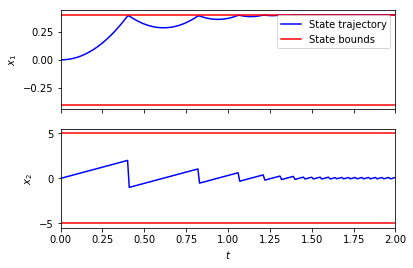

In [13]:
# push to the right wall with u=u_max
N_sim = 200
x0 = np.array([0., 0.])
x_sim, ms_sim = S.simulate(x0, [u_max]*N_sim)
plot_state_trajectory(x_sim, h, [x_min, x_max])

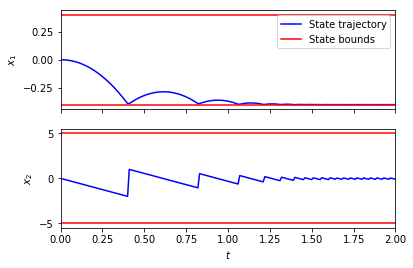

In [14]:
# push to the left wall with u=u_min
x_sim, ms_sim = S.simulate(x0, [u_min]*N_sim)
plot_state_trajectory(x_sim, h, [x_min, x_max])

# Example of condensation

In [19]:
# build controller no condensation
N = 60
Q = np.diag([1., 1.])*h
R = np.diag([1.])*h
P = Q
X_N = Polyhedron.from_bounds(*[np.zeros(S.nx)]*2)
controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, 'CH', 'two')

In [ ]:
# drive to the origin
x0 = np.array([0.,2.5])
u_opt, x_opt, ms_opt, cost_opt = controller.feedforward(x0)

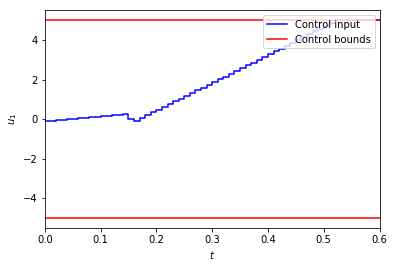

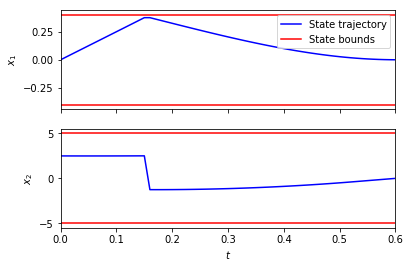

optimal cost: 3.10437001191


In [25]:
# plot result
plot_input_sequence(u_opt, h, [u_min, u_max])
plt.show()
plot_state_trajectory(x_opt, h, [x_min, x_max])
plt.show()

In [42]:
# number of stages to condense
condensed_stages = 2
assert N%condensed_stages == 0

# condensed system
S_c = S.condense_stages(condensed_stages)

# adpat numeric parameters
x0_c = np.concatenate((np.zeros((S.nx*(condensed_stages-1))), x0))
Q_c = block_diag(*[Q]*condensed_stages)
R_c = block_diag(*[R]*condensed_stages)
P_c = block_diag(*[Q]*(condensed_stages-1)+[P])
X_N_c = Polyhedron(
    np.hstack((np.zeros((X_N.A.shape[0], S.nx*(condensed_stages-1))), X_N.A)),
    X_N.b
)

In [43]:
# drive to the origin
controller_c = HybridModelPredictiveController(S_c, N/condensed_stages, Q_c, R_c, P_c, X_N_c, 'CH', 'two')
u_opt_c, x_opt_c, ms_opt_c, cost_opt_c = controller_c.feedforward(x0_c)

In [44]:
# check that the results match
assert np.isclose(cost_opt, cost_opt_c)
assert np.allclose(
    np.concatenate(u_opt),
    np.concatenate(u_opt_c)
)
assert np.allclose(
    np.concatenate(x_opt),
    np.concatenate(x_opt_c)[2:]
)

# Size of the MICP as a function of the number of stages we condense

We consider the PWA system obtained condensing $T$ stages of the original system in a single state update law.
We call $I$ the number of modes of this new system (i.e., the number of feasible transitions in a window of $T$ time steps).

Remark: When using the trick of building an equivalent PWA system to condense some stages of the problem, we increase the size of the state to be $T n_x$. So now, using the convex-hull method, in principle we should have $I$ copies of $x$, $u$, and $x_+$. However the $I-1$ of the copies of $x$ are useless (since re related columns of the dynamic matrix $A$ and the constraint matrix $F$ are zero) and can be safely removed from the problem.

Assuming to use the CH method, we have:

Number of feasible transitions: $I$

Number of binary variables per time step: $I/T$

Number of continuous variables per time step: $(n_x (T+1) + n_u T)I/T$

Number of equality constraints per time step: $(n_x I T + n_x (T+1) + n_u T + 1)/T$

Number of inequality constraints per time step: difficult to express in formula, see code

Binary assignment ^$1/T$: $I^{1/T}$

In [52]:
# assuming to use the CH method
condensed_stages_max = 6
for T in range(1,condensed_stages_max):
    f_ms = feasible_mode_sequences(S,T)[0]
    I = len(feasible_mode_sequences(S,T)[0])
    print '\nfeasible transitions:', I
    print 'binary variables/T:', I/float(T)
    print 'continuous variables/T:', (S.nx*(T+1)*I + S.nu*T*I)/float(T)
    print 'equalities/T:', (S.nx*T*I + S.nx*(T+1) + S.nu*T + 1)/float(T)
    print 'inequalities/T:', (sum(sum(S.domains[i].A.shape[0] for i in ms[0]) for ms in f_ms))/float(T)
    print 'binary assignment^1/T:', I**(1/float(T))


feasible transitions: 3
binary variables/T: 3.0
continuous variables/T: 15.0
equalities/T: 12.0
inequalities/T: 22.0
binary assignment^1/T: 3.0

feasible transitions: 5
binary variables/T: 2.5
continuous variables/T: 20.0
equalities/T: 14.5
inequalities/T: 38.0
binary assignment^1/T: 2.2360679775

feasible transitions: 9
binary variables/T: 3.0
continuous variables/T: 33.0
equalities/T: 22.0
inequalities/T: 68.6666666667
binary assignment^1/T: 2.08008382305

feasible transitions: 15
binary variables/T: 3.75
continuous variables/T: 52.5
equalities/T: 33.75
inequalities/T: 115.0
binary assignment^1/T: 1.96798967127

feasible transitions: 25
binary variables/T: 5.0
continuous variables/T: 85.0
equalities/T: 53.6
inequalities/T: 192.0
binary assignment^1/T: 1.90365393872
